In [23]:
from typing import List
from functools import wraps

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime as dt

jtplot.style(figsize=(15, 9))

In [2]:
# tickers = ['GLD', 'GDX', 'AAPL', 'SPY']
# # tickers = ['MSFT', 'NVDA', 'AMD', 'META']
# d_start = dt.datetime(2010, 1, 1)
# d_final = dt.datetime(2020, 12, 31)
#  period = '1d'

# df = yf.download(tickers, start=d_start, end=d_final, period=period, auto_adjust=True)
# df.to_csv(f"../../../data/bt/{'_'.join(tickers)}__{period.upper()}.csv")

In [2]:
import os

DATA_PATH = '../../data/bt/'

def read_csv_bt(csv:str)->pd.DataFrame:
    file_path = f"{DATA_PATH}{csv}"
    tickers, _ = csv.split('__')
    if len(tickers)>1:
        return pd.read_csv(file_path, parse_dates=True, header=[0, 1], index_col=0)['Close']
    else:
        return pd.read_csv(file_path, parse_dates=True, index_col=0)['Close']

def get_backtest_data()->List[list]:
    bt_files = os.listdir(DATA_PATH)
    csv_files = []
    for csv in bt_files:
        try:
            tickers, period = csv.split('__')
            df = read_csv_bt(csv) # send to some dict with data???
            csv_files.append({
                'csv': csv,
                'tickers': list(map(str.upper, tickers.split('_'))),
                'period': period.replace('.csv', ''),
                'start': df.iloc[0].name.strftime('%d/%m/%Y'),
                'end': df.iloc[-1].name.strftime('%d/%m/%Y')
            })
        except:
            continue
    return csv_files


## Strategies for testing

In [3]:
class Strategy:
    def __init__(self):
        pass
    
    def set_data(self, ticker:str, data:pd.DataFrame):
        self.data = data
        self.data['returns'] = np.log(self.data[ticker] / self.data[ticker].shift(1))
        self.ticker = ticker
        self.strategy = []
        self.drawdown = []
    
    def get_result(self):
        strategy_result = self.data[self.strategy+['returns']].sum().apply(np.exp)
        drawdown_result = self.data[self.drawdown].max()
        result = pd.concat([strategy_result, drawdown_result]).to_frame()
        result.rename(columns={0: self.ticker}, inplace=True)
        
        return result


In [4]:
class SMA(Strategy):
    def __init__(self, sma1:List[int]=[42], sma2:List[int]=[252]):
        self.sma1 = sma1
        self.sma2 = sma2
    
    def run_strategy(self):
        for s1, s2 in zip(self.sma1, self.sma2):
            self.data[f'SMA1_{s1}'] = self.data[self.ticker].rolling(s1).mean()
            self.data[f'SMA2_{s2}'] = self.data[self.ticker].rolling(s2).mean()
#             self.data.dropna(inplace=True) - ERROR

            self.data[f'position_{s1}_{s2}'] = np.where(self.data[f'SMA1_{s1}'] > self.data[f'SMA2_{s2}'], 1, -1)
            self.data[f'strategy_{s1}_{s2}'] = self.data[f'position_{s1}_{s2}'].shift(1) * self.data['returns']
            self.strategy.append(f'strategy_{s1}_{s2}')

            self.data[f'cumret_{s1}_{s2}'] = self.data[f'strategy_{s1}_{s2}'].cumsum().apply(np.exp)
            self.data[f'cummax_{s1}_{s2}'] = self.data[f'cumret_{s1}_{s2}'].cummax()
            self.data[f'drawdown_{s1}_{s2}'] = self.data[f'cummax_{s1}_{s2}'] - self.data[f'cumret_{s1}_{s2}']
            self.drawdown.append(f'drawdown_{s1}_{s2}')

        result = self.get_result()
    
        return result, self.data
    

In [5]:
class MOM(Strategy):
    def __init__(self, moms:List[int]=[1]):
        self.moms = moms
    
    def run_strategy(self):
        for mom in self.moms:
            self.data[f'MOM_{mom}'] = self.data[self.ticker].rolling(mom).mean()
#             self.data.dropna(inplace=True)

            self.data[f'position_{mom}'] = np.sign(self.data['returns'].rolling(mom).mean())
            self.data[f'strategy_{mom}'] = self.data[f'position_{mom}'].shift(1) * self.data['returns']
            self.strategy.append(f'strategy_{mom}')

            self.data[f'cumret_{mom}'] = self.data[f'strategy_{mom}'].cumsum().apply(np.exp)
            self.data[f'cummax_{mom}'] = self.data[f'cumret_{mom}'].cummax()
            self.data[f'drawdown_{mom}'] = self.data[f'cummax_{mom}'] - self.data[f'cumret_{mom}']
            self.drawdown.append(f'drawdown_{mom}')

        result = self.get_result()
    
        return result, self.data.copy()


In [6]:
class MeanRe(Strategy):
    def __init__(self, sma:List[int]=[25], threshold:float=3.5):
        self.sma = sma
        self.threshold = threshold
        
    def run_strategy(self):
        for s in self.sma:
            self.data['SMA'] = self.data[self.ticker].rolling(s).mean()
            self.data['distance'] = self.data[self.ticker] - self.data['SMA']
#             self.data['distance'].dropna(inplace=True)
            
            self.data[f'position_{s}'] = np.where(self.data['distance'] > self.threshold,
                                                  -1, np.nan)  
            self.data[f'position_{s}'] = np.where(self.data['distance'] < -self.threshold,
                                                  1, self.data[f'position_{s}'])  
            self.data[f'position_{s}'] = np.where(self.data['distance'] * self.data['distance'].shift(1) < 0,
                                                  0, self.data[f'position_{s}'])  
            self.data[f'position_{s}'] = self.data[f'position_{s}'].ffill().fillna(0)
            self.data[f'strategy_{s}'] = self.data[f'position_{s}'].shift(1) * self.data['returns']
            self.strategy.append(f'strategy_{s}')
            
            self.data[f'cumret_{s}'] = self.data[f'strategy_{s}'].cumsum().apply(np.exp)
            self.data[f'cummax_{s}'] = self.data[f'cumret_{s}'].cummax()
            self.data[f'drawdown_{s}'] = self.data[f'cummax_{s}'] - self.data[f'cumret_{s}']
            self.drawdown.append(f'drawdown_{s}')
            
        result = self.get_result()
        
        return result, self.data.copy()
    

In [7]:
class LinReg(Strategy):
    def __init__(self, lags:int=5):
        self.lags = lags
        
    def create_lags(self):
        cols = []
        for lag in range(1, self.lags + 1):
            col = f'lag_{lag}'
            self.data[col] = self.data[self.ticker].shift(lag) 
            cols.append(col)
        
        self.data.dropna(inplace=True)
        reg = np.linalg.lstsq(self.data[cols], np.sign(self.data['returns']), rcond=None)[0]
        self.data['prediction'] = np.dot(self.data[cols], reg)
    
    def run_strategy(self):
        self.create_lags()
        self.data['strategy'] = self.data['prediction'] * self.data['returns']
        self.strategy.append('strategy')
        
        self.data['cumret'] = self.data['strategy'].cumsum().apply(np.exp)
        self.data['cummax'] = self.data['cumret'].cummax()
        self.data['drawdown'] = self.data['cummax'] - self.data['cumret']
        self.drawdown.append('drawdown')
        
        result = self.get_result()
        
        return result, self.data.copy()
    

In [26]:
def bt_result_plot(test_full_data):
    for data in test_full_data:
        ticker = data.columns[0]
        cum_ret = data['returns'].cumsum().apply(np.exp)
        cumret_strategy_cols = []
        for c in data.columns:
            if 'cumret_' in c:
                cumret_strategy_cols.append(c)
        
        fig, ax = plt.subplots(1)
        if cumret_strategy_cols:
            strat_lines = ax.plot(data[cumret_strategy_cols], alpha=0.6)
            ax.plot(cum_ret, c='w')
            ax.set_title(ticker)
            ax.legend(cumret_strategy_cols+['Buy&Hold'])
        else:
            ax.plot(cum_ret, c='g', label='Buy&Hold')
            ax.plot(data['strategy'].cumsum().apply(np.exp), c='b', label='strategy')
            ax.set_title(ticker)
            ax.legend()


In [9]:
def start_backtesting(strategy_cls, *args)->list:
    bt_results_dfs = []
    full_data_dfs = []
    bt_data_files = get_backtest_data()
    for bt in bt_data_files:
        csv, tickers, period, _, _ = bt.values()
        data = read_csv_bt(csv)

        single_ticker_result = []
        full_data_cnt = []
        STRATEGY = get_strategy(strategy_cls, *args)
        for ticker in tickers:
            STRATEGY.set_data(ticker, pd.DataFrame(data[ticker]))
            result, full_data = STRATEGY.run_strategy()
            
            single_ticker_result.append(result)
            full_data_cnt.append(full_data)

        single_ticker_result = pd.concat(single_ticker_result, axis=1)
        single_ticker_result.index.name = period
        bt_results_dfs.append(single_ticker_result)
        full_data_dfs.append(full_data_cnt)
        
    return bt_results_dfs, full_data_dfs
        
def get_strategy(strategy, *args):
    strategies = dict(
        sma=SMA,
        mom=MOM,
        mean_re=MeanRe,
        lin_reg=LinReg,
    )
    return strategies[strategy](*args)


In [17]:
result, full_data = start_backtesting('lin_reg')

In [36]:
result[0]

,GLD,GDX,AAPL,SPY
1D,,,,
strategy,1.041194,1.304719,1.465592,1.603616
returns,1.595582,0.788926,20.475029,4.039678
drawdown,0.042742,0.122199,0.062010,0.088188


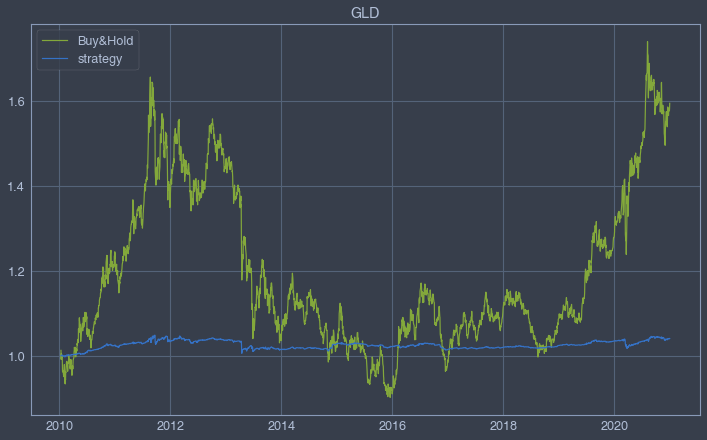

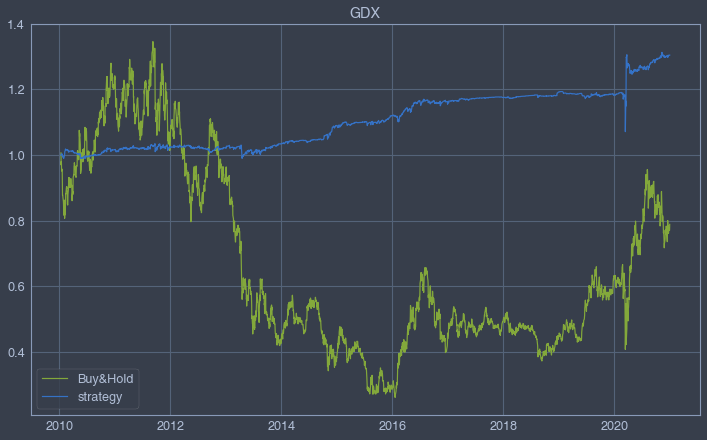

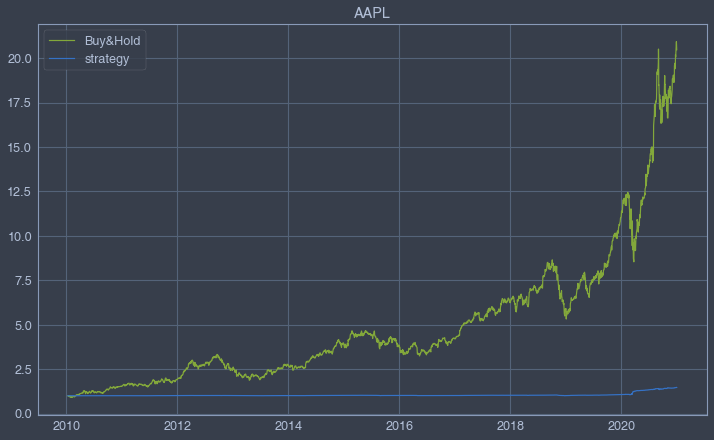

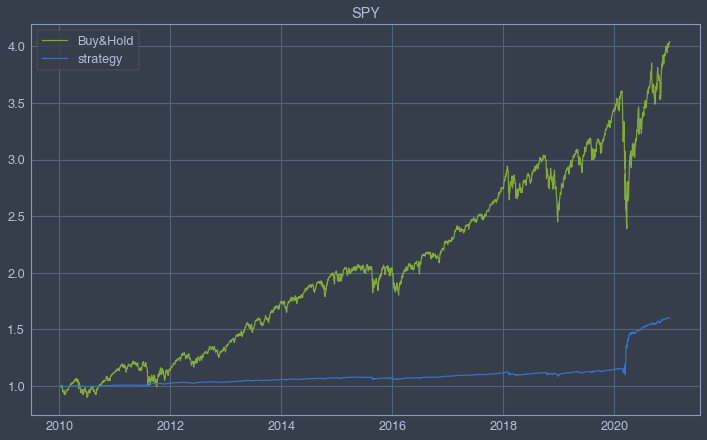

In [27]:
bt_result_plot(full_data[0])

In [15]:
SMA1 = [42, 24, 18, 6]
SMA2 = [252, 180, 64, 22]
result, full_data = start_backtesting('sma', SMA1, SMA2)

In [21]:
result[0]

,GLD,GDX,AAPL,SPY
1D,,,,
strategy_42_252,1.198594,0.584841,5.612339,1.187630
strategy_24_180,1.240472,0.741269,6.231742,1.435445
strategy_18_64,1.474584,0.479329,2.683968,1.334395
strategy_6_22,1.940321,1.874675,4.890418,0.793566
returns,1.618397,0.824147,20.280812,4.083878
drawdown_42_252,0.354154,0.883276,2.724951,0.551123
drawdown_24_180,0.498471,0.724200,1.572654,0.919438
drawdown_18_64,0.495136,0.932772,0.937450,0.409172
drawdown_6_22,0.428153,2.111855,1.163426,0.784892


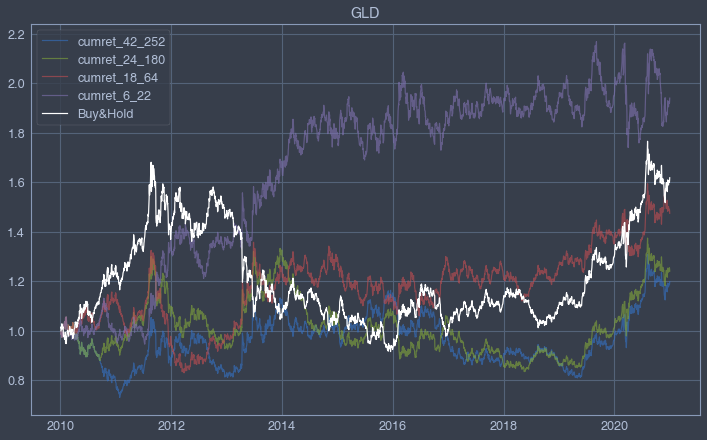

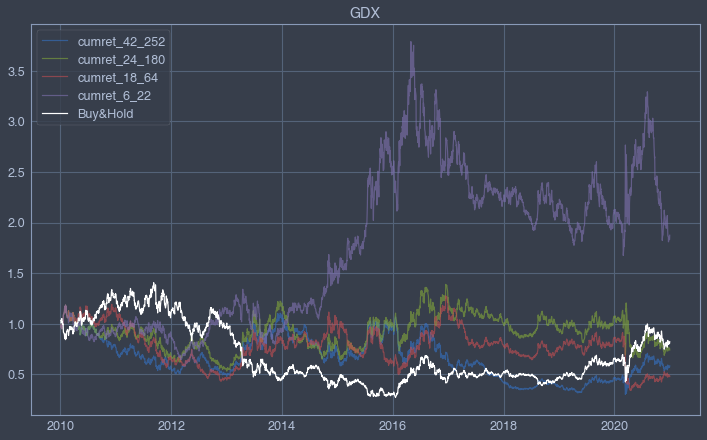

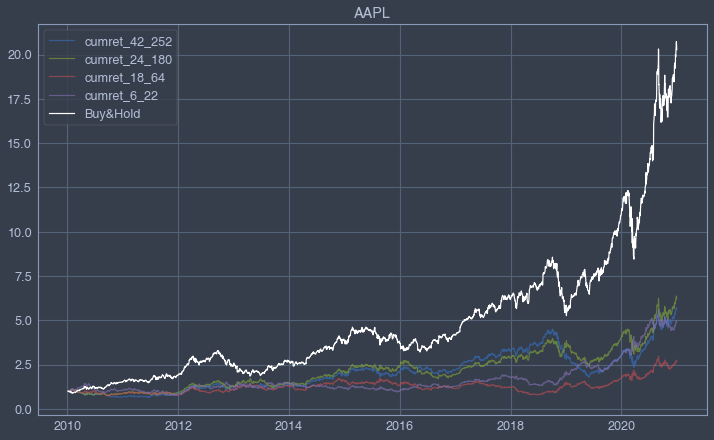

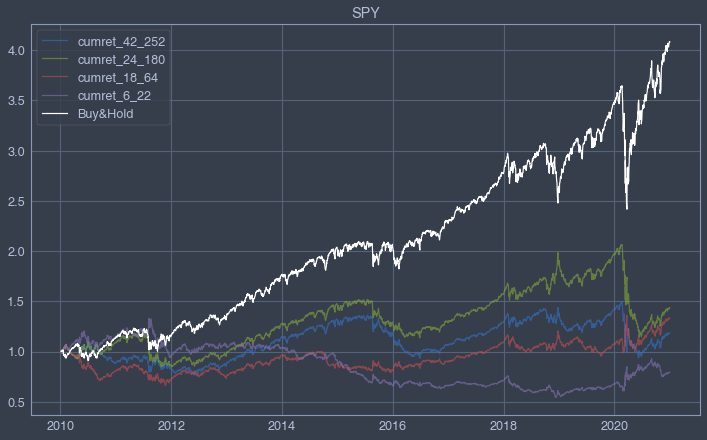

In [24]:
bt_result_plot(full_data[0])

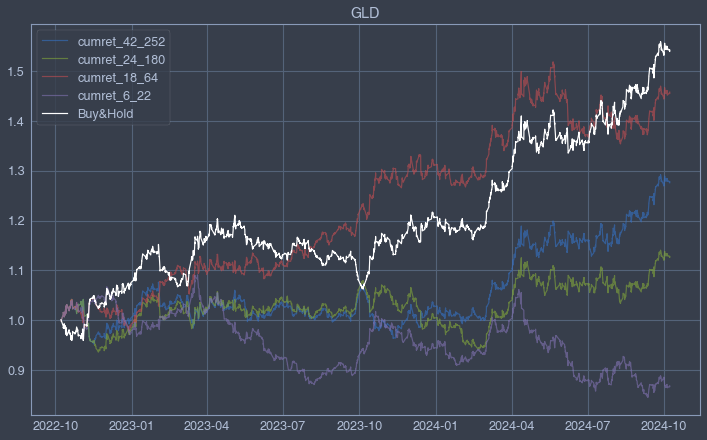

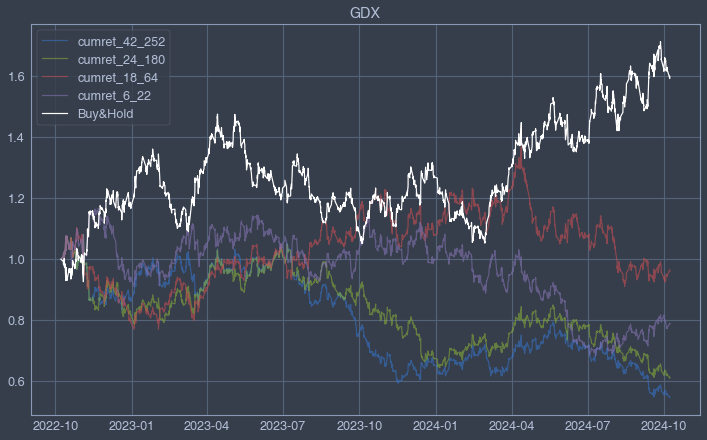

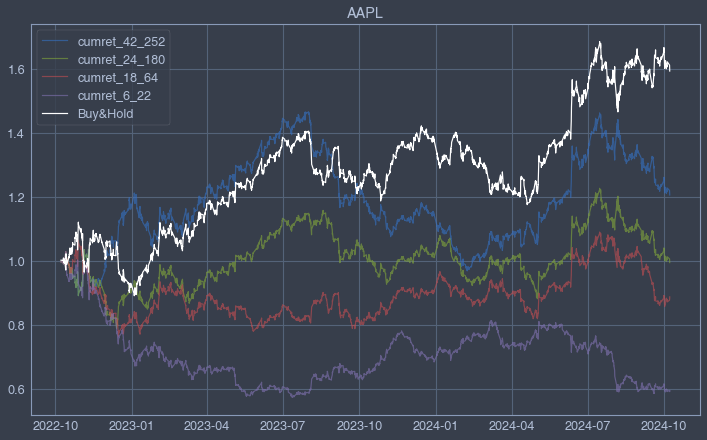

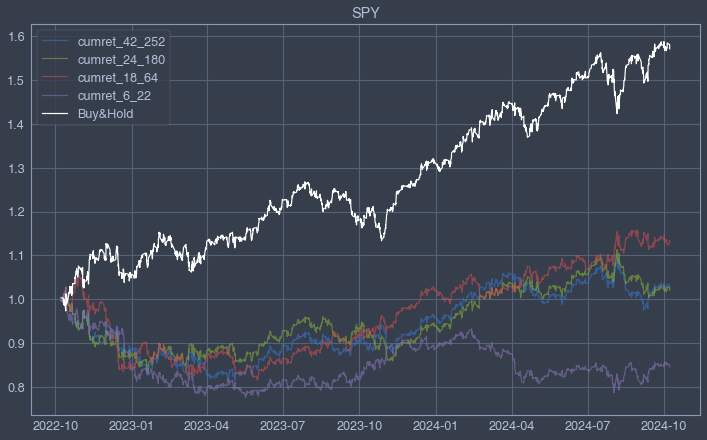

In [25]:
bt_result_plot(full_data[1])

In [26]:
result, full_data = start_backtesting('mom', [10])

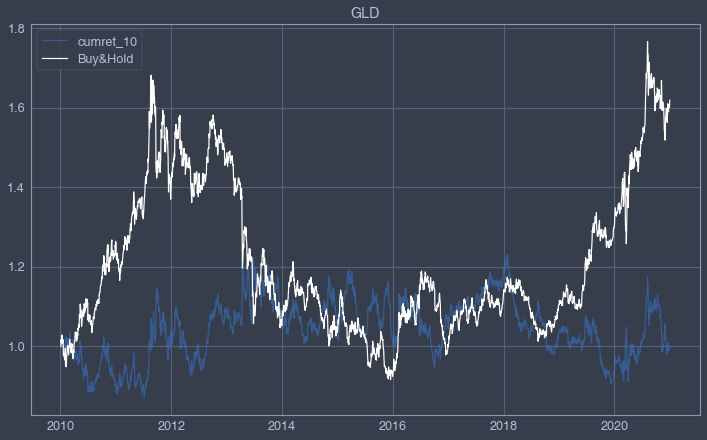

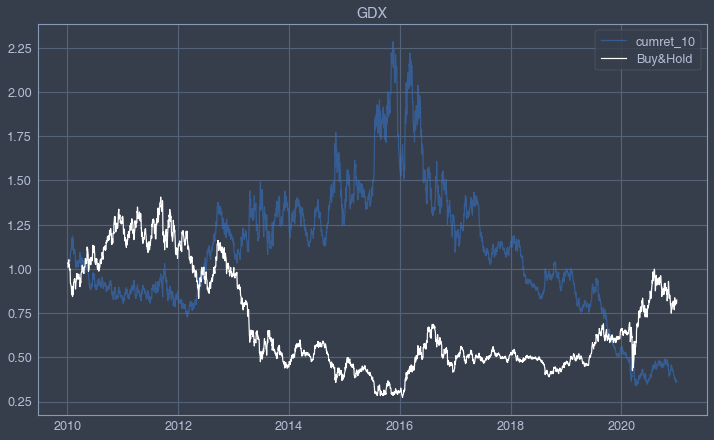

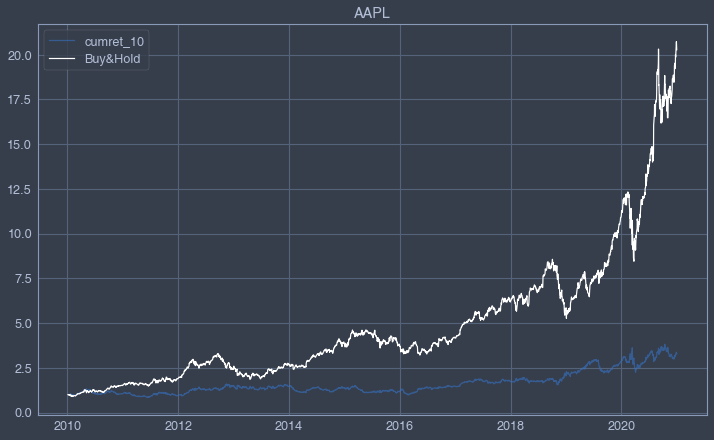

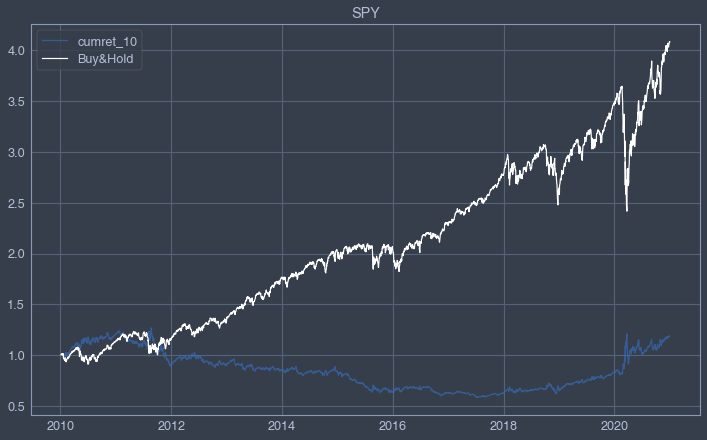

In [27]:
bt_result_plot(full_data[0])

In [28]:
result, full_data = start_backtesting('mean_re')

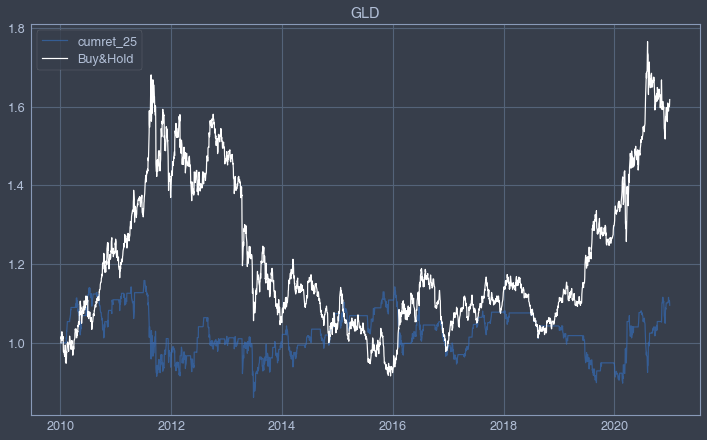

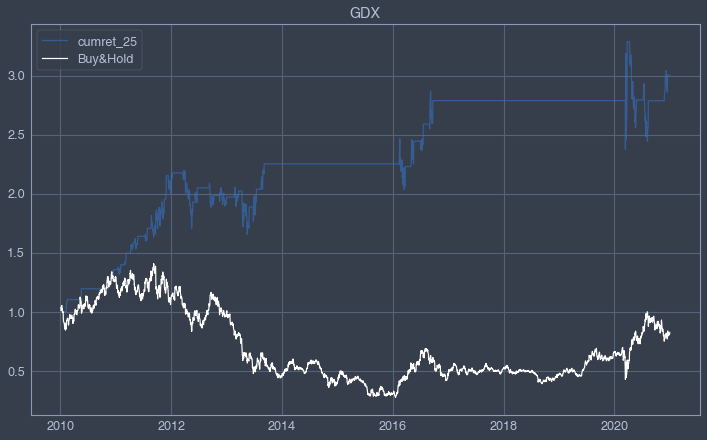

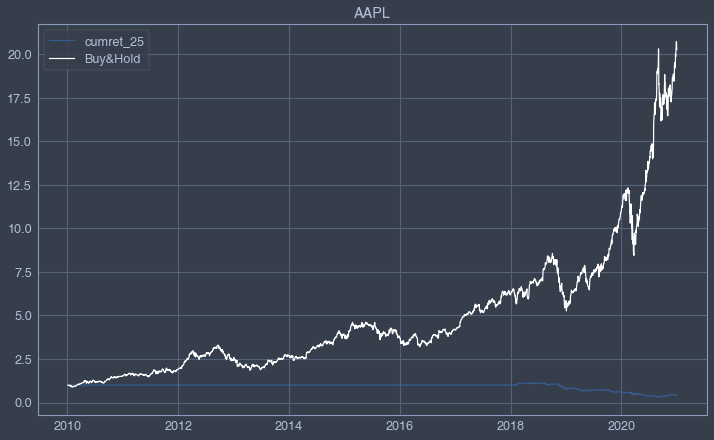

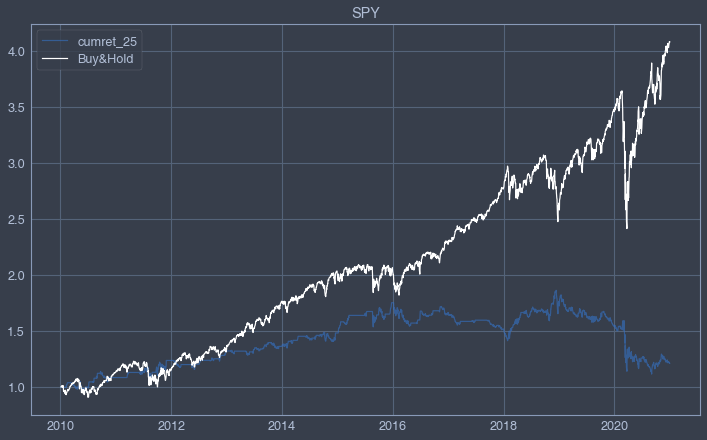

In [29]:
bt_result_plot(full_data[0])